In [9]:
import pandas as pd

#Load the CSV file
df = pd.read_csv("C:/Users/test/Desktop/Health/Data/public_health_dataset.csv")

#Preview the data
print(df.head())
print(df.info())

   report_id        date      location age_group  gender    disease  cases  \
0          1  2023-01-31       Houston     35-49    Male   Diabetes      5   
1          2  2023-12-30  Philadelphia     50-64  Female     Asthma      6   
2          3  2022-05-10     San Diego       65+    Male   COVID-19      5   
3          4  2023-07-18   San Antonio     35-49  Female  Influenza      5   
4          5  2023-02-04       Chicago      0-17  Female  Influenza      2   

   hospitalizations  deaths  
0                 0       0  
1                 0       0  
2                 0       0  
3                 0       0  
4                 0       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   report_id         1000000 non-null  int64 
 1   date              1000000 non-null  object
 2   location          1000000 non-null  object


In [13]:
#Clening the data
#Convert date to datetime
df['date'] = pd.to_datetime(df['date'])

#Check for missing values
print(df.isnull().sum())

#Fill or drop missing data
df.dropna(inplace=True)

report_id           0
date                0
location            0
age_group           0
gender              0
disease             0
cases               0
hospitalizations    0
deaths              0
dtype: int64


In [15]:
#Total cases, deaths, hospitalizations
print("Total Cases:", df['cases'].sum())
print("Total Deaths:", df['deaths'].sum())
print("Total Hospitalizations:", df['hospitalizations'].sum())

#Cases by disease
print(df.groupby('location')['deaths'].sum().sort_values(ascending=False))

#Deaths by Location
print(df.groupby('location')['deaths'].sum().sort_values(ascending=False))

Total Cases: 4999492
Total Deaths: 10099
Total Hospitalizations: 499083
location
New York        1072
Philadelphia    1048
San Diego       1030
Los Angeles     1022
Houston         1013
Phoenix         1012
Chicago          997
San Antonio      991
San Jose         962
Dallas           952
Name: deaths, dtype: int64
location
New York        1072
Philadelphia    1048
San Diego       1030
Los Angeles     1022
Houston         1013
Phoenix         1012
Chicago          997
San Antonio      991
San Jose         962
Dallas           952
Name: deaths, dtype: int64


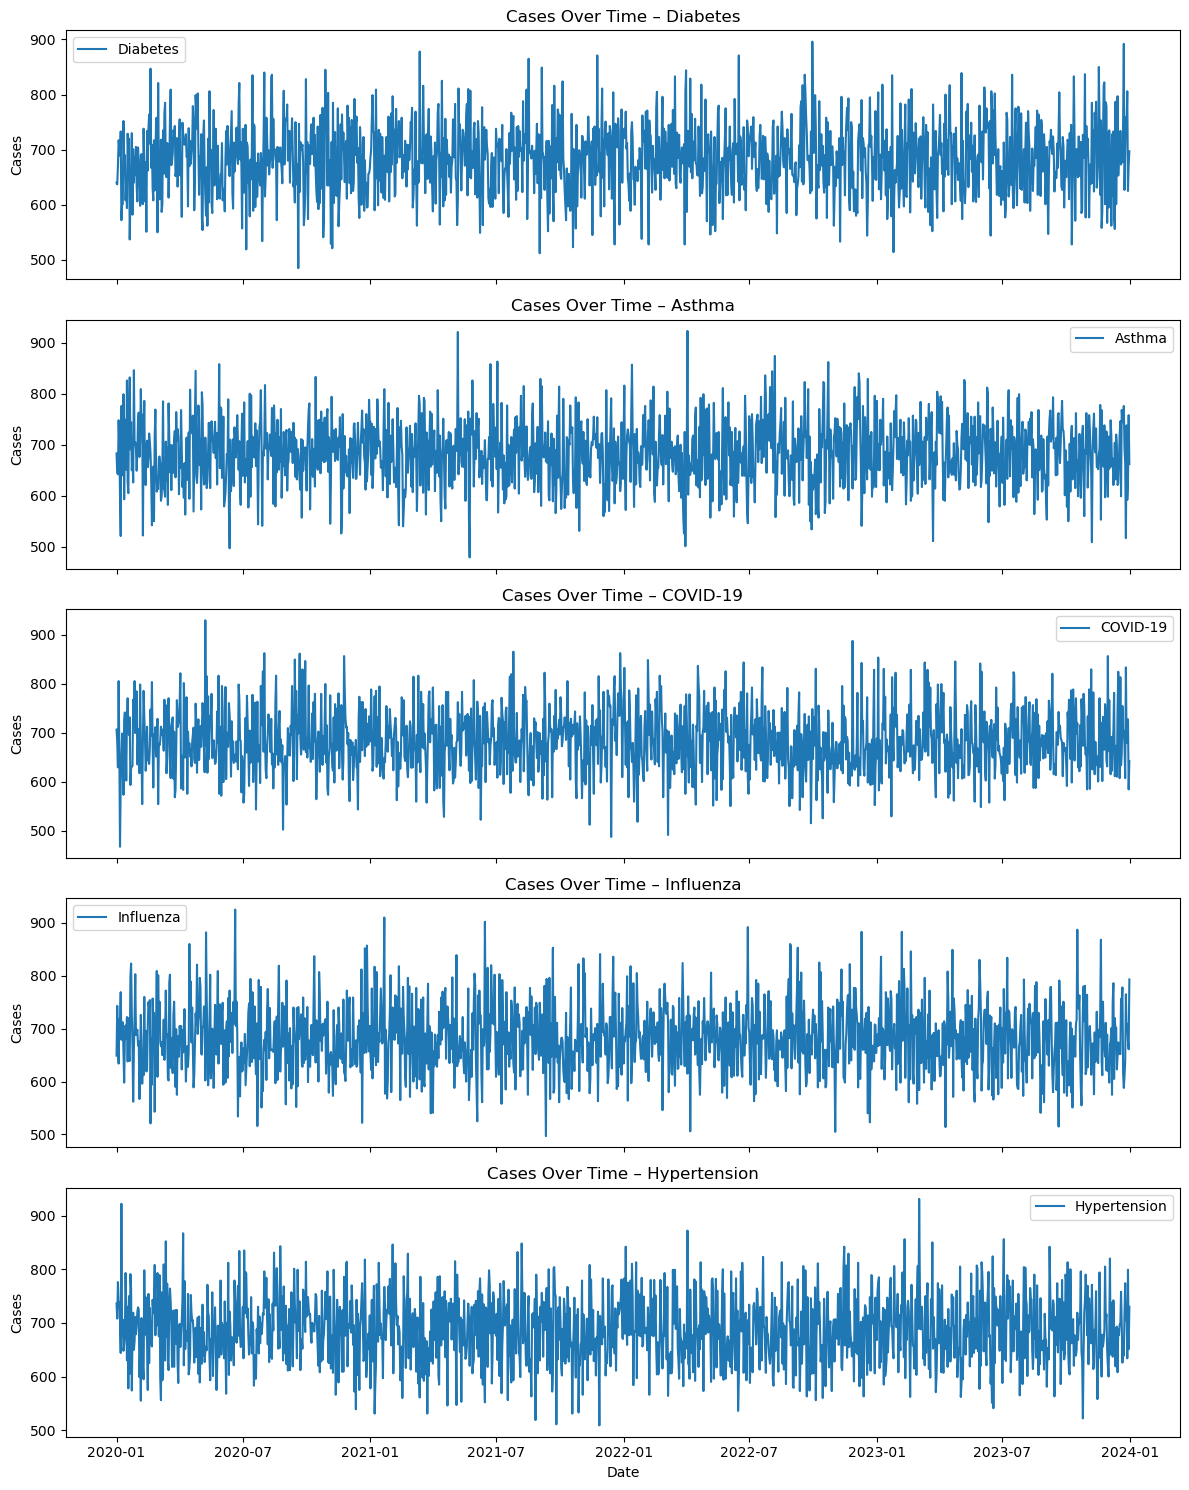

In [25]:
diseases = df['disease'].unique()
cases_by_date = df.groupby(['date', 'disease'])['cases'].sum().unstack()

fig, axes = plt.subplots(nrows=len(diseases), ncols=1, figsize=(12, 3 * len(diseases)), sharex=True)

for i, disease in enumerate(diseases):
    axes[i].plot(cases_by_date.index, cases_by_date[disease], label=disease)
    axes[i].set_title(f"Cases Over Time – {disease}")
    axes[i].set_ylabel("Cases")
    axes[i].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()


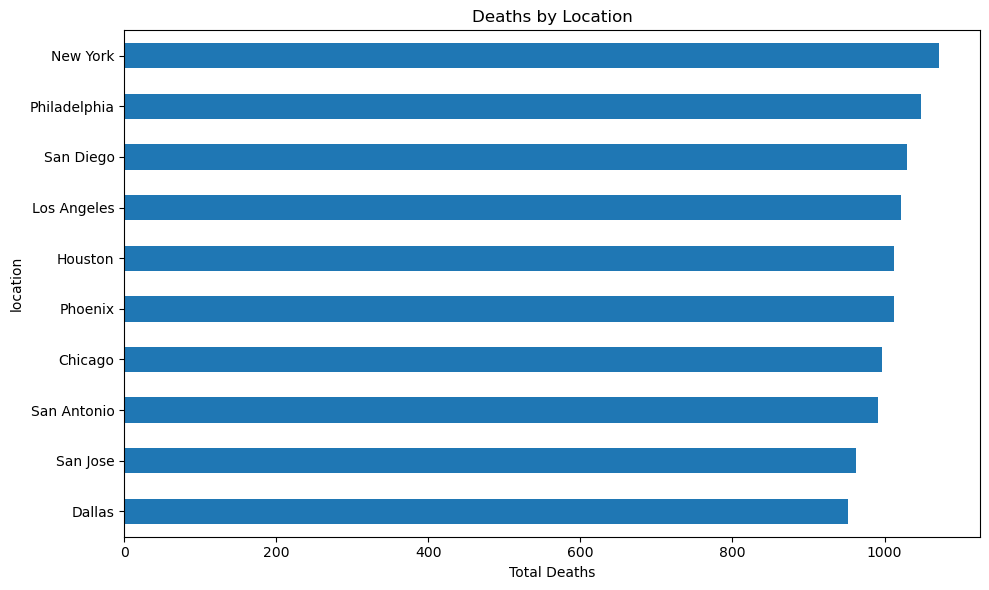

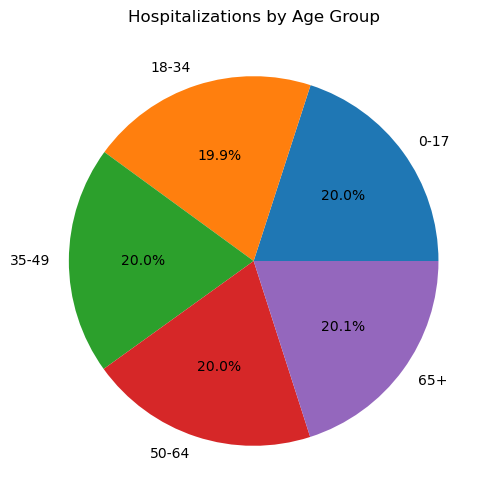

In [27]:
#Deaths by Location
df.groupby('location')['deaths'].sum().sort_values().plot(kind='barh', figsize=(10,6), title="Deaths by Location")
plt.xlabel("Total Deaths")
plt.tight_layout()
plt.show()

#Hospitalizations by age group
df.groupby('age_group')['hospitalizations'].sum().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6), title="Hospitalizations by Age Group")
plt.ylabel("")
plt.show()

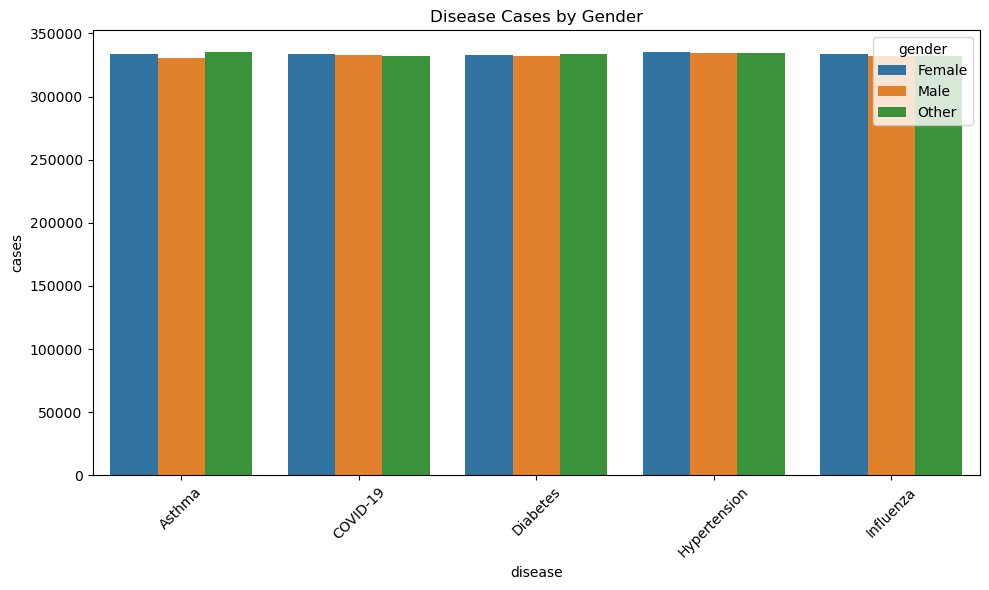

In [19]:
#Gender-wise Disease Spread
import seaborn as sns

gender_disease = df.groupby(['gender', 'disease'])['cases'].sum().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=gender_disease, x='disease', y='cases', hue='gender')
plt.title("Disease Cases by Gender")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
pip install dash pandas plotly


   ---------------------------------------- 0.0/7.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.9 MB 991.0 kB/s eta 0:00:08
   - -------------------------------------- 0.3/7.9 MB 3.8 MB/s eta 0:00:03
   ----- ---------------------------------- 1.1/7.9 MB 8.8 MB/s eta 0:00:01
   ----------- ---------------------------- 2.4/7.9 MB 13.6 MB/s eta 0:00:01
   ------------------- -------------------- 4.0/7.9 MB 18.0 MB/s eta 0:00:01
   ------------------------- -------------- 5.1/7.9 MB 19.2 MB/s eta 0:00:01
   ------------------------------------ --- 7.1/7.9 MB 22.9 MB/s eta 0:00:01
   ---------------------------------------  7.9/7.9 MB 24.1 MB/s eta 0:00:01
   ---------------------------------------- 7.9/7.9 MB 22.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [35]:
import dash
from dash import dcc, html, Input, Output, State, ctx
import pandas as pd
import plotly.express as px

# Load data
df = pd.read_csv("C:/Users/test/Desktop/Health/Data/public_health_dataset.csv")
df['date'] = pd.to_datetime(df['date'])

# Initialize app
app = dash.Dash(__name__)
app.title = "Public Health Dashboard"

# Layout
app.layout = html.Div([
    html.H1("🩺 Public Health Dashboard", style={'textAlign': 'center'}),

    html.Div([
        html.Label("Select Disease"),
        dcc.Dropdown(
            id='disease-filter',
            options=[{'label': d, 'value': d} for d in df['disease'].unique()],
            value=['COVID-19'],
            multi=True
        ),

        html.Label("Select Date Range"),
        dcc.DatePickerRange(
            id='date-range',
            min_date_allowed=df['date'].min(),
            max_date_allowed=df['date'].max(),
            start_date=df['date'].min(),
            end_date=df['date'].max()
        )
    ], style={'width': '60%', 'margin': 'auto'}),

    html.Div(id='summary-kpis', style={
        'display': 'flex', 'justifyContent': 'space-around', 'margin': '20px'
    }),

    html.Div([
        html.Button("Download Filtered Data", id="btn-download"),
        dcc.Download(id="download-dataframe-csv"),
    ], style={'textAlign': 'center', 'marginBottom': '20px'}),

    dcc.Graph(id='cases-over-time'),
    dcc.Graph(id='deaths-by-location'),
    dcc.Graph(id='hospitalizations-by-age'),
    dcc.Graph(id='gender-disease-bar')
])

# Main dashboard callback
@app.callback(
    [Output('summary-kpis', 'children'),
     Output('cases-over-time', 'figure'),
     Output('deaths-by-location', 'figure'),
     Output('hospitalizations-by-age', 'figure'),
     Output('gender-disease-bar', 'figure')],
    [Input('disease-filter', 'value'),
     Input('date-range', 'start_date'),
     Input('date-range', 'end_date')]
)
def update_dashboard(diseases, start_date, end_date):
    dff = df[(df['disease'].isin(diseases)) &
             (df['date'] >= start_date) &
             (df['date'] <= end_date)]

    # KPIs
    total_cases = dff['cases'].sum()
    total_deaths = dff['deaths'].sum()
    total_hosp = dff['hospitalizations'].sum()
    summary = [
        html.Div([html.H3(f"{total_cases:,}"), html.P("Total Cases")], style={'textAlign': 'center'}),
        html.Div([html.H3(f"{total_deaths:,}"), html.P("Total Deaths")], style={'textAlign': 'center'}),
        html.Div([html.H3(f"{total_hosp:,}"), html.P("Total Hospitalizations")], style={'textAlign': 'center'})
    ]

    # Charts
    fig_cases = px.line(
        dff.groupby(['date', 'disease'])['cases'].sum().reset_index(),
        x='date', y='cases', color='disease',
        title="Cases Over Time"
    )

    fig_deaths = px.bar(
        dff.groupby('location')['deaths'].sum().sort_values().tail(10).reset_index(),
        x='deaths', y='location', orientation='h',
        title="Top 10 Locations by Deaths"
    )

    fig_hospitalizations = px.pie(
        dff.groupby('age_group')['hospitalizations'].sum().reset_index(),
        values='hospitalizations', names='age_group',
        title="Hospitalizations by Age Group"
    )

    fig_gender = px.bar(
        dff.groupby(['gender', 'disease'])['cases'].sum().reset_index(),
        x='disease', y='cases', color='gender', barmode='group',
        title="Cases by Gender and Disease"
    )

    return summary, fig_cases, fig_deaths, fig_hospitalizations, fig_gender

# Download callback
@app.callback(
    Output("download-dataframe-csv", "data"),
    Input("btn-download", "n_clicks"),
    State("disease-filter", "value"),
    State("date-range", "start_date"),
    State("date-range", "end_date"),
    prevent_initial_call=True
)
def download_filtered(n_clicks, diseases, start_date, end_date):
    filtered_df = df[(df['disease'].isin(diseases)) &
                     (df['date'] >= start_date) &
                     (df['date'] <= end_date)]
    return dcc.send_data_frame(filtered_df.to_csv, "filtered_public_health_data.csv")

# Run app
if __name__ == '__main__':
    app.run(debug=True)
